In [77]:
import pandas as pd
import numpy as np
import spacy
import re
import string
import seaborn as sns
from matplotlib import pyplot as plt
from warnings import filterwarnings
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [28]:
filterwarnings(action='ignore')

In [29]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [30]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [31]:
# num of missing values

print('num of NaNs in the keywords: ', train_df.keyword.isna().sum())
print('num of NaNs in the locations: ', train_df.location.isna().sum())
print('num of NaNs in the text: ', train_df.text.isna().sum())

num of NaNs in the keywords:  61
num of NaNs in the locations:  2533
num of NaNs in the text:  0


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'train set')]

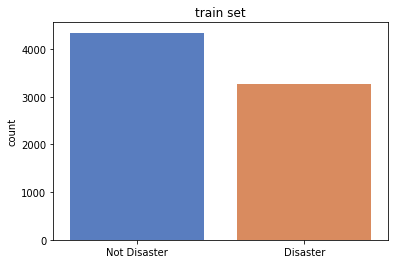

In [32]:
# target distribution

results = train_df.groupby('target', as_index=False)['id'].count()
g = sns.barplot(['Not Disaster', 'Disaster'], results['id'], palette='muted')
g.set(ylabel='count', title='train set')

## Lowercasing

In [34]:
# train set
train_df['keyword'] = train_df['keyword'].apply(
    lambda x: str.lower(x) if pd.isna(x) != True else x)

train_df['location'] = train_df['location'].apply(
    lambda x: str.lower(x) if pd.isna(x) != True else x)

train_df['text'] = train_df['text'].apply(lambda x: str.lower(x))

# test set
test_df['keyword'] = test_df['keyword'].apply(
    lambda x: str.lower(x) if pd.isna(x) != True else x)

test_df['location'] = test_df['location'].apply(
    lambda x: str.lower(x) if pd.isna(x) != True else x)

test_df['text'] = test_df['text'].apply(lambda x: str.lower(x))

## Checking stopwords

In [47]:
from collections import defaultdict
def stop_word_finder(text):
    sw = defaultdict(int)
    sw_nltk = set(stopwords.words('english'))
    
    # splitting words in a tweet
    words = []
    for x in text['text'].str.split():
        for i in x:
            words.append(i)
            
    # finding stop words in the tweets
    for word in words:
        if word in sw_nltk:
            sw[word]+=1
    return sw

<BarContainer object of 30 artists>

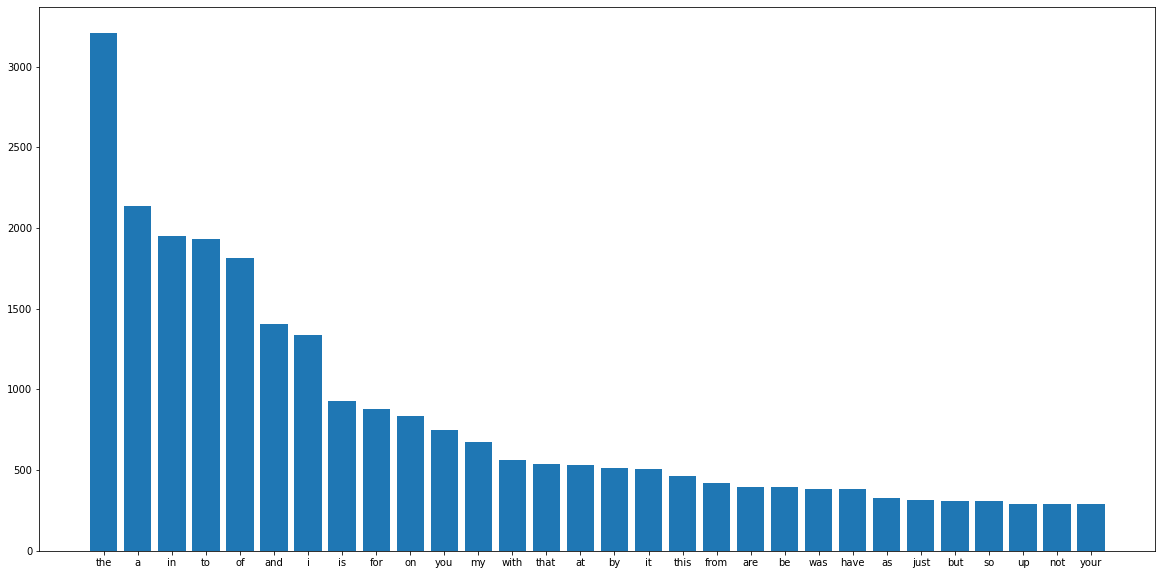

In [57]:
df_stop_words = stop_word_finder(train_df)

# sorting
tops = sorted(df_stop_words.items(), key=lambda x:x[1],reverse=True)[:30]

# unzipping
x,y = zip(*tops)

# ploting
plt.figure(figsize=(20, 10))
plt.bar(x, y)

In [43]:
sw_nltk = set(stopwords.words('english'))

## Remove URL and HTML tags

In [63]:
def url_remover(text):
    text = re.sub(
        r'/(?:(?:https?|ftp|file):\/\/|www\.|ftp\.)(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[-A-Z0-9+&@#\/%=~_|$?!:,.])*         (?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[A-Z0-9+&@#\/%=~_|$])/igm', ' ', text)

    return text

In [64]:
# train set
train_df['keyword'] = train_df['keyword'].apply(
    lambda x: url_remover(x) if pd.isna(x) != True else x)

train_df['location'] = train_df['location'].apply(
    lambda x: url_remover(x) if pd.isna(x) != True else x)

train_df['text'] = train_df['text'].apply(lambda x: url_remover(x))

# test set
test_df['keyword'] = test_df['keyword'].apply(
    lambda x: url_remover(x) if pd.isna(x) != True else x)

test_df['location'] = test_df['location'].apply(
    lambda x: url_remover(x) if pd.isna(x) != True else x)

test_df['text'] = test_df['text'].apply(lambda x: url_remover(x))

## Remove punctuation marks

In [65]:
def punctuation_remover(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

In [66]:
train_df['keyword'] = train_df['keyword'].apply(
    lambda x: punctuation_remover(x) if pd.isna(x) != True else x)

train_df['location'] = train_df['location'].apply(
    lambda x: punctuation_remover(x) if pd.isna(x) != True else x)

train_df['text'] = train_df['text'].apply(lambda x: punctuation_remover(x))

# test set
test_df['keyword'] = test_df['keyword'].apply(
    lambda x: punctuation_remover(x) if pd.isna(x) != True else x)

test_df['location'] = test_df['location'].apply(
    lambda x: punctuation_remover(x) if pd.isna(x) != True else x)

test_df['text'] = test_df['text'].apply(lambda x: punctuation_remover(x))

## Remove Emojies

In [59]:
def emoji_remover(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [60]:
train_df['text'] = train_df['text'].apply(lambda x: emoji_remover(x))

## Spell correction

In [67]:
spell = SymSpell()

dict_path = './frequency_dictionary_en_82_765.txt'
spell.load_dictionary(dict_path, 0, 1)

False

In [68]:
def spell_correction(text):
    corrected = []
    for token in text.split(' '):
        x = spell.lookup(token, Verbosity.CLOSEST,
                         max_edit_distance=2, include_unknown=True)[0].__str__()
        y = x.split(',')[0]
        corrected.append(y)

    return ' '.join(corrected)

In [69]:
train_df['keyword'] = train_df['keyword'].apply(
    lambda x: spell_correction(x) if pd.isna(x) != True else x)

train_df['location'] = train_df['location'].apply(
    lambda x: spell_correction(x) if pd.isna(x) != True else x)

train_df['text'] = train_df['text'].apply(lambda x: spell_correction(x))

# test set
test_df['keyword'] = test_df['keyword'].apply(
    lambda x: spell_correction(x) if pd.isna(x) != True else x)

test_df['location'] = test_df['location'].apply(
    lambda x: spell_correction(x) if pd.isna(x) != True else x)

test_df['text'] = test_df['text'].apply(lambda x: spell_correction(x))

In [71]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are ...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation or...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


## Word cloud

### Disaster

In [85]:
def wordcloud_plot(df, target):
    words = []
    for x in df[df['target'] == target]['text'].str.split():
        for i in x:
            words.append(i)
            
    # plotting
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(words[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

Disaster


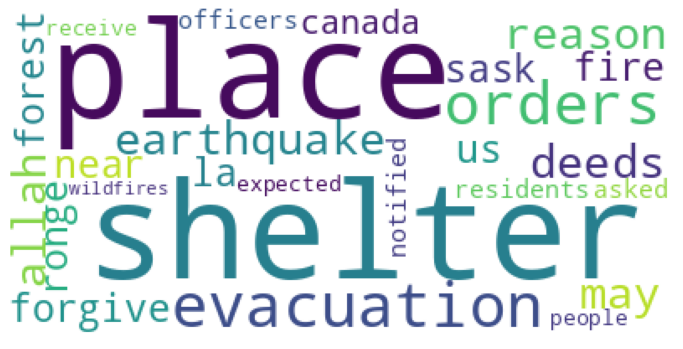

In [86]:
print('Disaster')
wordcloud_plot(train_df, 1)

### Not disaster

Not A Disaster


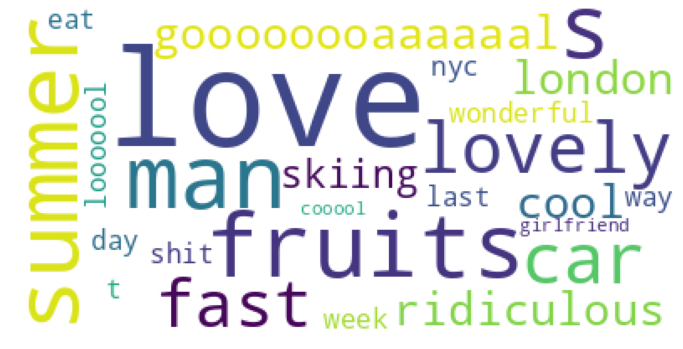

In [87]:
print('Not A Disaster')
wordcloud_plot(train_df, 0)